In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn
from IPython.display import clear_output, display, Video
from torch_cluster import knn
from torch_geometric.nn.conv import GENConv
from tqdm import tqdm

sys.path.append('../src')
from util import get_particles, grab_plot, show_particles, VideoWriter

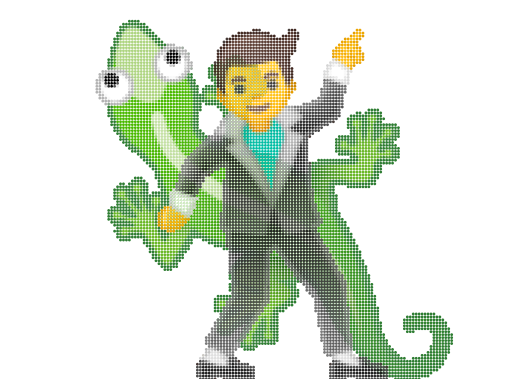

In [78]:
SEED_PATH = '../images/lizard.png'
TARGET_PATH = '../images/dancer.png'

seed_particles = get_particles(SEED_PATH, n_channels=16)
target_particles = get_particles(TARGET_PATH)
show_particles(seed_particles, target_particles)

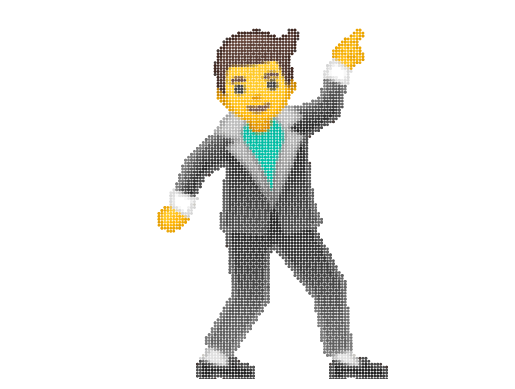

In [12]:
mask = (torch.linspace(0, target_particles.shape[0] - 1, seed_particles.shape[0]) + .5).long()
show_particles(target_particles[mask])

In [ ]:
def ot_loss(x, y, particle_dim=5, projection_dim=128):
    projection = torch.normal(0., 1., (particle_dim, projection_dim))
    projection /= projection.square().sum(0, keepdim=True).sqrt()
    points = (x[:, :particle_dim]@projection).T.sort()[0]
    target = (y@projection).T.sort()[0]
    mask = (torch.linspace(0, target.shape[-1] - 1, x.shape[0]) + .5).long()
    target = target[..., mask]
    loss = (points - target).square().sum()/projection_dim

    return loss

x = seed_particles.clone().requires_grad_()
# mask = torch.linspace(0, target_particles.shape[0] - 1, seed_particles.shape[0]).long()
# y = target_particles[mask[torch.randperm(mask.shape[0])]]
y = target_particles.clone()
optimizer = torch.optim.SGD([x], 1.)

with VideoWriter() as video:
    for i in tqdm(range(500)):
        show_particles(x.detach(), show=False)
        video.write(grab_plot())
        loss = ot_loss(x, y)*i/100
        # loss = (x[:, :5] - y).square().sum(-1).sqrt().sum()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 500/500 [00:34<00:00, 14.61it/s]


In [79]:
def ot_loss(x, y, particle_dim=2, projection_dim=128):
    projection = torch.normal(0., 1., (particle_dim, projection_dim))
    projection /= projection.square().sum(0, keepdim=True).sqrt()
    points = (x[:, :particle_dim]@projection).T.sort()[0]
    target = (y@projection).T.sort()[0]
    mask = (torch.linspace(0, target.shape[-1] - 1, x.shape[0]) + .5).long()
    target = target[..., mask]
    loss = (points - target).square().sum()/projection_dim

    return loss

class NPA(nn.Module):
    def __init__(self, n_neighbors=9, hidden_dim=128, n_layers=3, loss_function=ot_loss):
        super().__init__()

        self.n_neighbors = n_neighbors
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.loss_function = loss_function

        self.perception_net = None
        self.update_net = None
        self.edges = None
        self.optimizer = None
        # self.scheduler = None
        self.loss_log = []

    def build(self, seed, n_epochs=1000, learning_rate=1e-4):
        input_dim = seed.shape[-1]
        self.perception_net = GENConv(input_dim, self.hidden_dim, num_layers=2)
        self.update_net = GENConv(self.hidden_dim, input_dim, num_layers=self.n_layers)
        self.edges = knn(seed[:, :2], seed[:, :2], 1)
        self.optimizer = torch.optim.SGD(self.parameters(), learning_rate)
        # self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, learning_rate, n_epochs)

        return self

    def forward(self, x, update_rate=1e-4, n_steps=1):
        for _ in range(n_steps):
            edges = knn(x[:, :2], x[:, :2], self.n_neighbors)
            dx = self.perception_net(x, edges).relu()
            dx = self.update_net(dx, self.edges)
            y = x + dx*update_rate

        return y
    
    def step(self, x, target):
        loss = self.loss_function(x[:, :2], target[:, :2])
        loss.backward()
        self.optimizer.step()
        optimizer.zero_grad()
        # self.scheduler.step()

        return loss.item()
    
    def display(self, x, step, verbosity=2, display_rate=10):
        if verbosity == 2 and step%display_rate == 0:
            show_particles(x, clear=True)
            plt.plot(np.arange(len(self.loss_log)), self.loss_log)
            plt.show()
    
    def train(self, seed, target, n_epochs=1000, learning_rate=1e-2, update_rate=1e-4, min_steps=64, verbosity=2, display_rate=10):
        self.build(seed, n_epochs, learning_rate)
        max_steps = min_steps + 1

        for i in tqdm(range(n_epochs)) if verbosity > 0 else range(n_epochs):
            x = seed.clone()
            n_steps = torch.randint(min_steps, int(max_steps), (1,))
            x = self(x, update_rate, n_steps)
            loss = self.step(x, target)
            self.loss_log.append(loss)
            max_steps += min_steps/n_epochs
            self.display(x[:, :5].detach(), i, verbosity, display_rate)

        return self

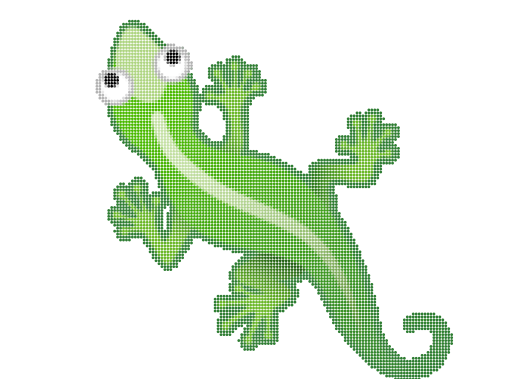

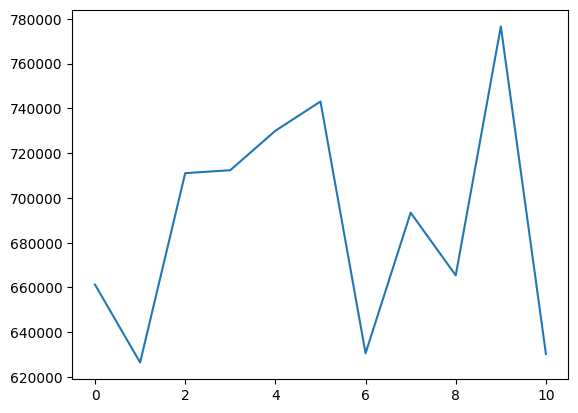

  1%|          | 12/1000 [00:29<41:06,  2.50s/it]


KeyboardInterrupt: 

In [80]:
model = NPA()
model.train(seed_particles, target_particles)

In [77]:
x = seed_particles.clone()

with VideoWriter() as video:
    for _ in tqdm(range(100)):
        show_particles(x.detach(), show=False)
        video.write(grab_plot())
        x = model(x)

100%|██████████| 100/100 [00:06<00:00, 16.50it/s]
